In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10,6)})
# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import CategoricalImputer
from sklearn.multiclass import OneVsRestClassifier

# to convert the 1-D target vector in to a matrix
from sklearn.preprocessing import label_binarize

from sklearn.metrics import roc_curve, roc_auc_score

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import (
    roc_auc_score,
    plot_roc_curve,
)

from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    auc,
)

from yellowbrick.classifier import PrecisionRecallCurve

# Helper Functions

In [2]:
## Confusion Matrix
def conf_matrix(y_test, col, y_pred):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test[col], y_pred)
    cf_norm = cf_matrix.astype("float") / cf_matrix.sum(axis=1)[:, np.newaxis] # normalize it

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['({0:.2%})'.format(value) for value in cf_norm.flatten()]
    group_counts = ['Count = {0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(2,2)


    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues') #cmap='binary' #cmap='Blues'

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label")

    plt.show(block=False)

In [3]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    
      """
      Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
      will be used.

      Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).

      Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

      Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
      """  
      # Create the confustion matrix
      sns.set_theme(style="white")
      cm = confusion_matrix(y_true, y_pred)
      cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
      n_classes = cm.shape[0] # find the number of classes we're dealing with

      # Plot the figure and make it pretty
      fig, ax = plt.subplots(figsize=figsize)
      cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
      fig.colorbar(cax)

      # Are there a list of classes?
      if classes:
        labels = classes
      else:
        labels = np.arange(cm.shape[0])

      # Label the axes
      ax.set(title="Confusion Matrix",
             xlabel="Predicted label",
             ylabel="True label",
             xticks=np.arange(n_classes), # create enough axis slots for each class
             yticks=np.arange(n_classes), 
             xticklabels=labels, # axes will labeled with class names (if they exist) or ints
             yticklabels=labels)

      # Make x-axis labels appear on bottom
      ax.xaxis.set_label_position("bottom")
      ax.xaxis.tick_bottom()

      # Set the threshold for different colors
      threshold = (cm.max() + cm.min()) / 2.

      # Plot the text on each cell
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

In [4]:
def plot_distribution(data, column):
    plt.figure()
    sns.set(rc={'figure.figsize':(6,4)})
    data[column].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(column)
    plt.ylabel('count')

In [5]:
!pip install openpyxl

# EDA

In [6]:
path = r"C:\Users\yudhi\OneDrive\Desktop\School\Courses\Data_Mining\Data"
os.chdir(path)

In [7]:
#read data in chunks of 1 million rows at a time
df = pd.read_excel('SKDB.xlsx', dtype='object')

df.head(3)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  


,Number,Name,Prison ID,Alias or AKA,Type of Killer,Sex,Race,WhiteMale,WhiteMale20s,NumVics,...,1920,1910,1900,Century,Decade Started,Other information,Nickname,Organizational,Parole Comment,FGCU Record
0,SK05436,"Aal, Mohammed Abdel",NaN,NaN,Serial - Organizational - Gang,1,1,1,NaN,17,...,1,1,0,1900,1910,NaN,NaN,1,NaN,NaN
1,SK05443,"Aataminpoika, Juhani",NaN,NaN,Serial,1,1,1,0,12,...,0,0,0,1800,1840,NaN,NaN,0,NaN,NaN
2,SK00001,"Abbott, Jack Henry",UT 86A005,"Eastman, Jack",Serial - Two murders,1,1,1,0,2,...,0,0,0,1900,1960,NaN,NaN,0,On parole for murder,1


In [8]:
df.shape

(5746, 191)

In [9]:
all_killer_cols = ['Name', 'Sex', 'Race', 'NumVics', 'Country', 'US', 'birthyear', 'Age1stKill', 'AgeLastKill', 'Age Group', 'DateFirst', 'DateFinal', 'Victim Code', 'Aamodt Code', 'Aamodt Type', 'Raised', 'Educ', 'Marital Status', 'Sexual Orientation', 'Broad Occupation', 'Previous jail or prison time', 'Kill Method', 'Partner', "LocKilling","YearFirst","YearFinal"]
killer_cols = ['Sex', 'Race', 'Age Group', 'Sexual Orientation', 'Marital Status', "YearFirst","YearFinal", 'Country','US']
killing_process = ['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill', 'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Totem', 'Necrophilia', 'AteBody', 'DrankBlood', 'Posed', 'Body Totem', 'Item Totem']
cleaning_process = ['BodyLeft', 'LeftHidden', 'LeftBuried', 'Moved', 'MovedHide', 'MovedBuried', 'Placed in body of water', 'Body Burned', 'Dismembered', 'TakenHome']
vic_cols = ['VicSex', 'Race of Victim', 'Primary Victim Age']

cols = killing_process + cleaning_process + vic_cols + killer_cols

In [10]:
# Filter necessary columns
data = df[cols]

#Filter necessary date and country
data = data[(data.Country == 'US' ) & (data.US == 1) & (data.YearFinal >= 1976) &(data.YearFinal <= 2020)]
data.head()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Totem,Necrophilia,...,Primary Victim Age,Sex,Race,Age Group,Sexual Orientation,Marital Status,YearFirst,YearFinal,Country,US
2,0,0,0,0,1,0,0,0,0,0,...,Adults,1,1,20,1,1,1966,1981,US,1
4,0,0,1,1,NaN,0,0,0,NaN,0,...,Adults,1,2,20,NaN,1,2009,2011,US,1
7,1,0,1,0,0,0,0,0,NaN,0,...,Adults,1,1,40,1,NaN,1982,1993,US,1
8,1,0,1,0,0,0,0,0,0,0,...,Adults,1,2,10,1,NaN,1970,1990,US,1
9,0,0,1,0,NaN,0,0,0,0,0,...,Elderly,1,1,20,1,4,1983,2010,US,1


In [11]:
data.shape

(2878, 37)

In [12]:
df_year = data[['YearFinal']].reset_index(drop=True)
df_year.head()

,YearFinal
0,1981
1,2011
2,1993
3,1990
4,2010


In [13]:
df_year = df_year.groupby('YearFinal').size().reset_index(name='count')
df_year = df_year.set_index('YearFinal')
df_year

,count
YearFinal,
1976,37
1977,41
1978,77
1979,53
1980,71
1981,72
1982,72
1983,63
1984,81


<AxesSubplot:xlabel='YearFinal'>

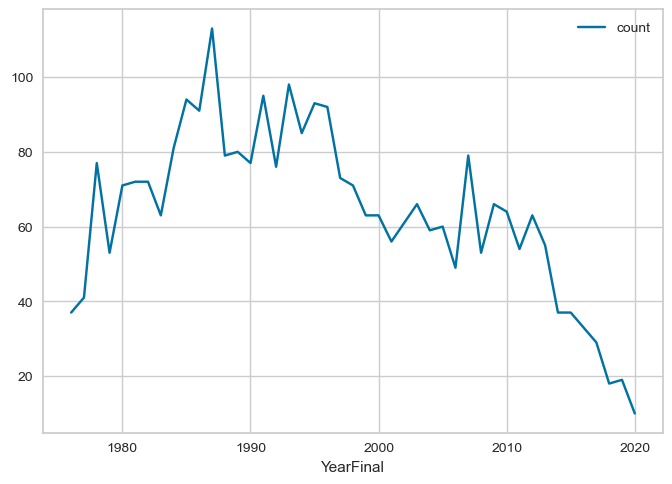

In [14]:
df_year.plot()

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Databse Shape
data.shape

(2878, 37)

In [17]:
# Get total of missing values for each variable
data.isnull().sum()

Sexual Assault               78
Torture                     147
Sought victim to kill       235
Overkill                    212
Quick                       715
Blindfold                   301
Bound                       229
Mutilate                    102
Totem                      1890
Necrophilia                  29
AteBody                      27
DrankBlood                   27
Posed                        43
Body Totem                   43
Item Totem                 2362
BodyLeft                     99
LeftHidden                  119
LeftBuried                   97
Moved                       116
MovedHide                   115
MovedBuried                  98
Placed in body of water     252
Body Burned                 244
Dismembered                  88
TakenHome                    96
VicSex                       60
Race of Victim              162
Primary Victim Age           56
Sex                           0
Race                         17
Age Group                    33
Sexual O

In [18]:
# The average missing values in each variable
data.isnull().mean()

Sexual Assault             0.027102
Torture                    0.051077
Sought victim to kill      0.081654
Overkill                   0.073662
Quick                      0.248436
Blindfold                  0.104587
Bound                      0.079569
Mutilate                   0.035441
Totem                      0.656706
Necrophilia                0.010076
AteBody                    0.009382
DrankBlood                 0.009382
Posed                      0.014941
Body Totem                 0.014941
Item Totem                 0.820709
BodyLeft                   0.034399
LeftHidden                 0.041348
LeftBuried                 0.033704
Moved                      0.040306
MovedHide                  0.039958
MovedBuried                0.034051
Placed in body of water    0.087561
Body Burned                0.084781
Dismembered                0.030577
TakenHome                  0.033356
VicSex                     0.020848
Race of Victim             0.056289
Primary Victim Age         0

#### Variables with > 5% but < 10% missing data: "Sought victim to kill", "Overkill", "Bound", "Placed in body of water", "Body Burned"

#### Variables with >= 10% missing data: "Quick", "Blindfold", "Totem", "Item Totem"

## Data Cleaning: Delete Wrong-Value Rows

In [19]:
# Dropping wrong label rows
i = data[df.VicSex == 7.0].index
data.drop(i, inplace=True)

i = data[data['Necrophilia']=='?'].index
data.drop(i, inplace=True)

i = data[data['Sought victim to kill']==' '].index
data.drop(i, inplace=True)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [20]:
# # remove rows where target is null (MICE as alternative for imputation in targets)
# print("Before = ", data.shape)
# data.dropna(subset=['Sex', 'Race'], axis=0, inplace=True)
# print("After = ", data.shape)

In [21]:
data.isnull().mean()

Sexual Assault             0.027130
Torture                    0.051130
Sought victim to kill      0.081739
Overkill                   0.073739
Quick                      0.248696
Blindfold                  0.104348
Bound                      0.079652
Mutilate                   0.035478
Totem                      0.656696
Necrophilia                0.010087
AteBody                    0.009391
DrankBlood                 0.009391
Posed                      0.014609
Body Totem                 0.014957
Item Totem                 0.820522
BodyLeft                   0.034435
LeftHidden                 0.041391
LeftBuried                 0.033739
Moved                      0.040348
MovedHide                  0.040000
MovedBuried                0.034087
Placed in body of water    0.087652
Body Burned                0.084870
Dismembered                0.030609
TakenHome                  0.033043
VicSex                     0.020870
Race of Victim             0.056348
Primary Victim Age         0

# Victims

In [22]:
data.columns[:-3]

Index(['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill',
       'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Totem', 'Necrophilia',
       'AteBody', 'DrankBlood', 'Posed', 'Body Totem', 'Item Totem',
       'BodyLeft', 'LeftHidden', 'LeftBuried', 'Moved', 'MovedHide',
       'MovedBuried', 'Placed in body of water', 'Body Burned', 'Dismembered',
       'TakenHome', 'VicSex', 'Race of Victim', 'Primary Victim Age', 'Sex',
       'Race', 'Age Group', 'Sexual Orientation', 'Marital Status',
       'YearFirst'],
      dtype='object')

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


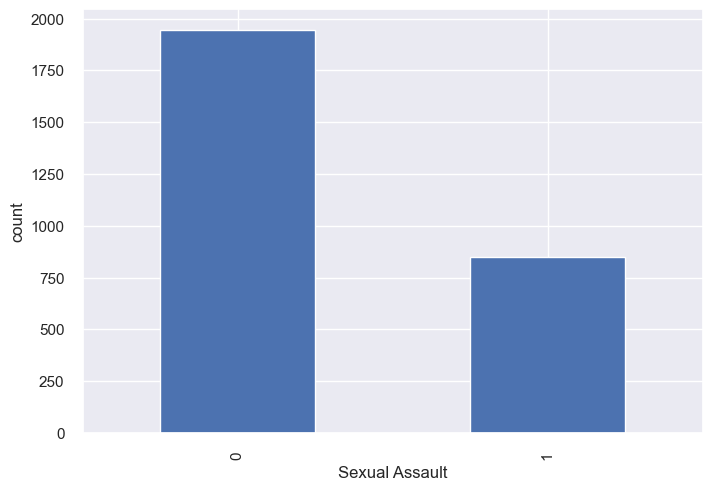

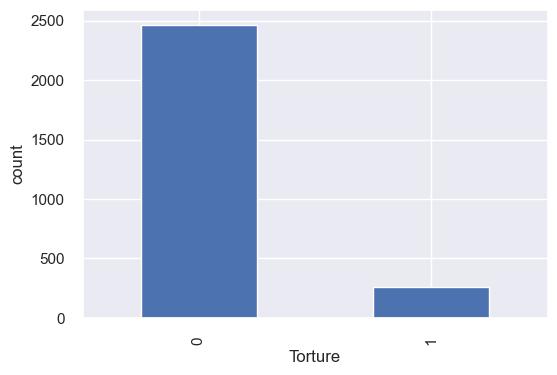

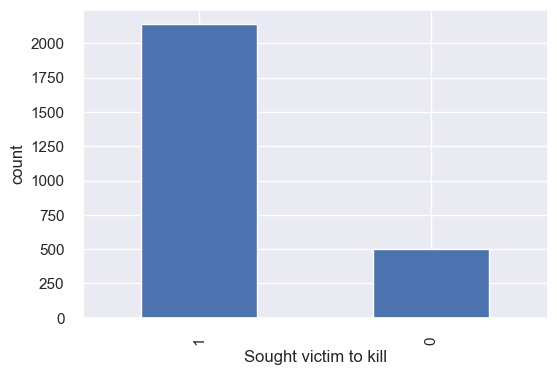

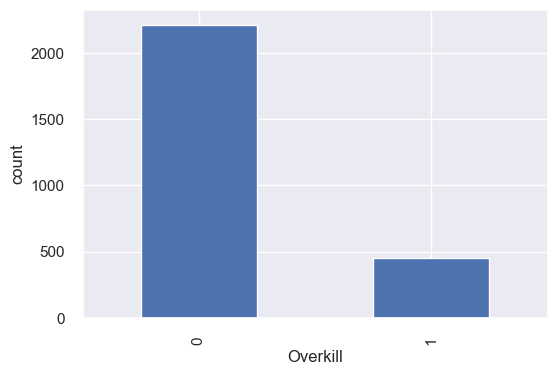

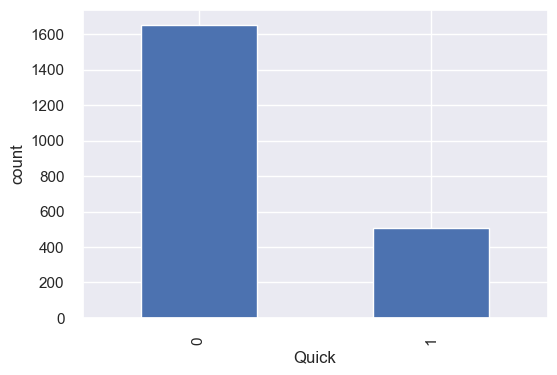

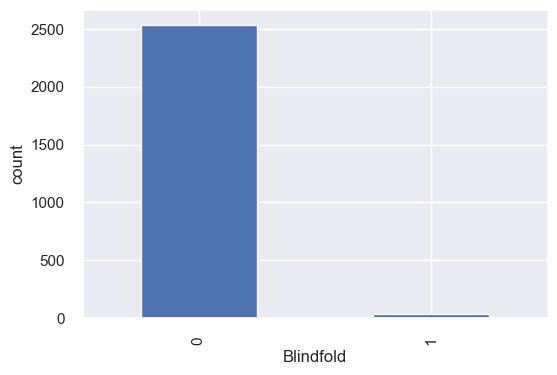

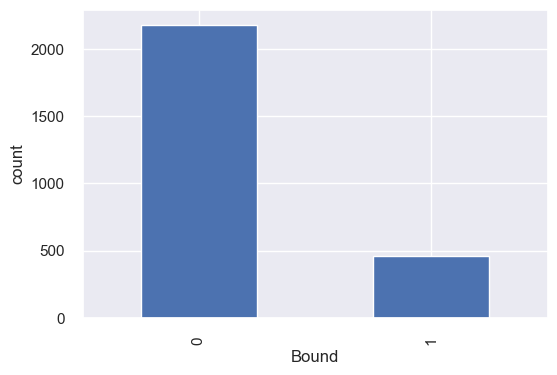

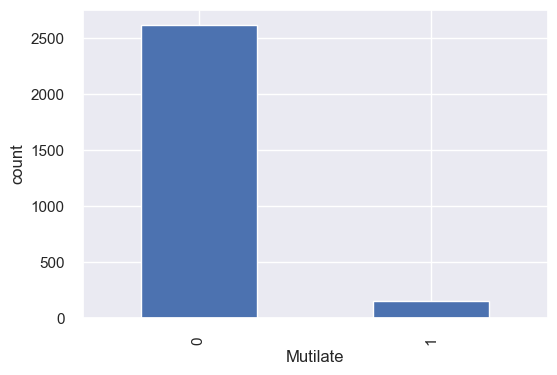

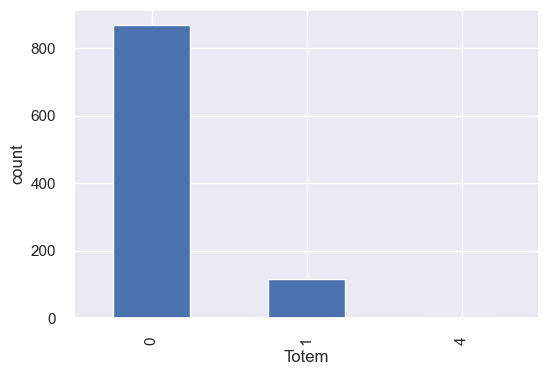

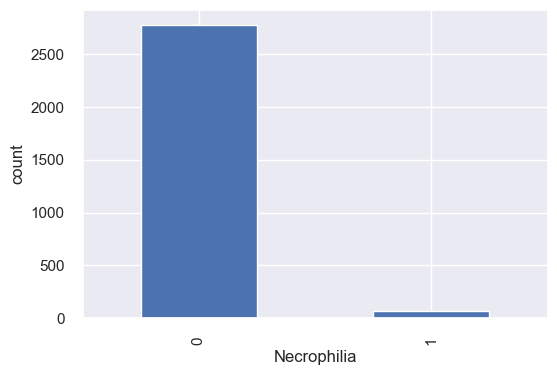

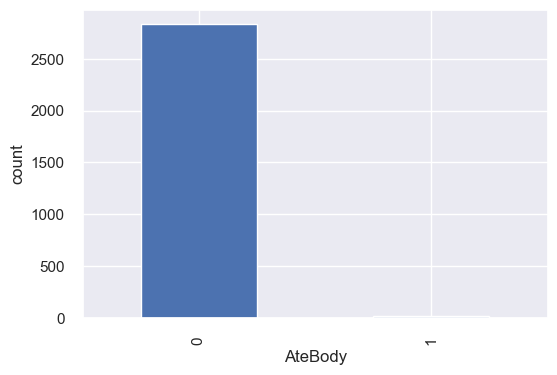

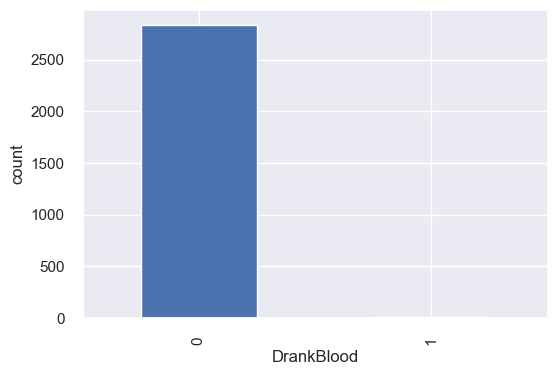

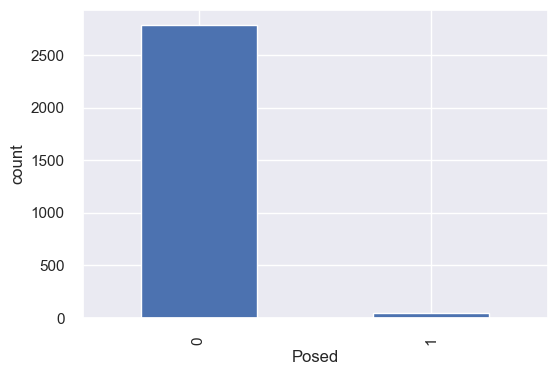

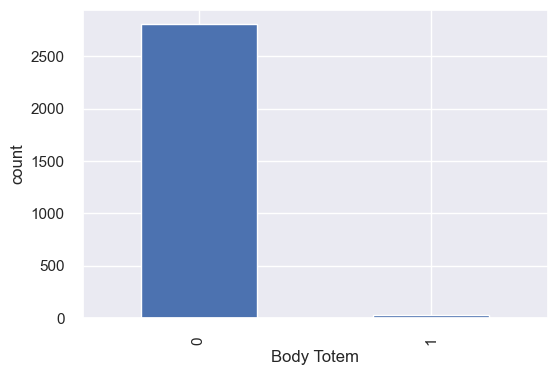

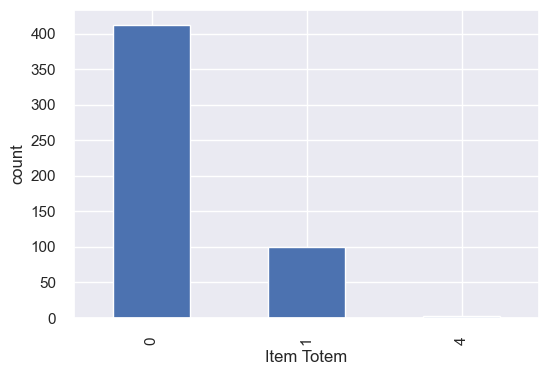

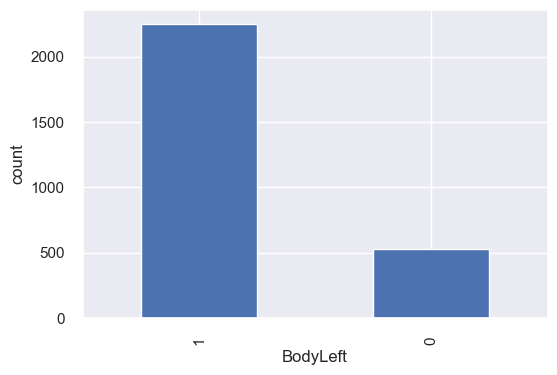

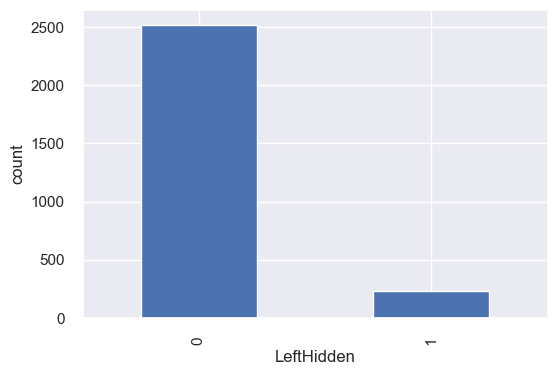

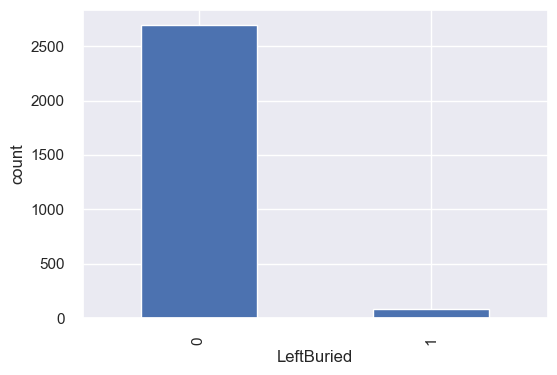

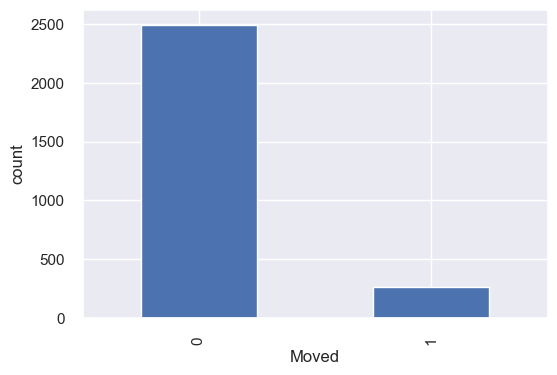

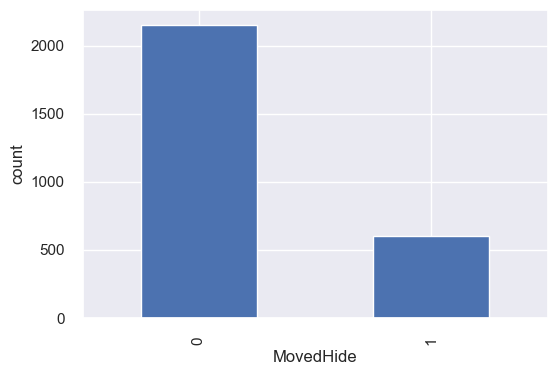

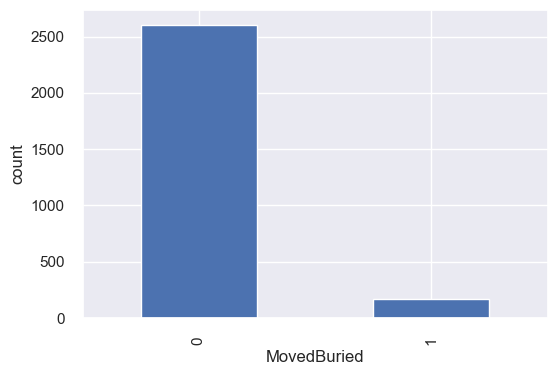

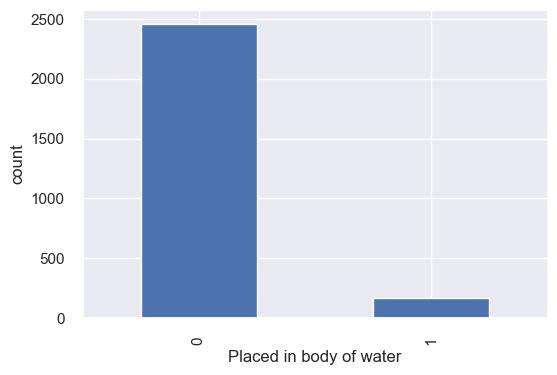

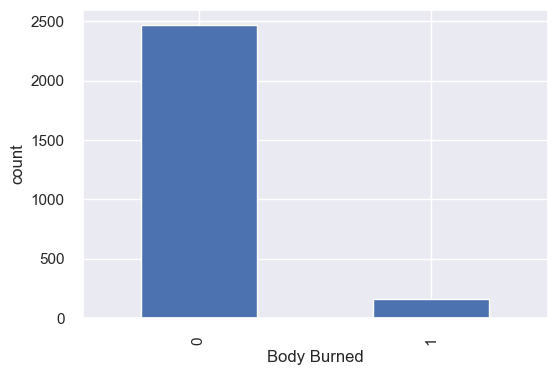

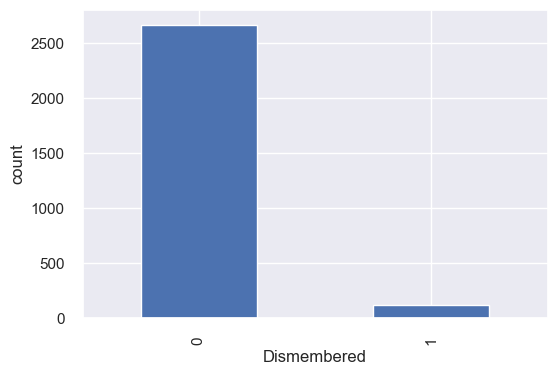

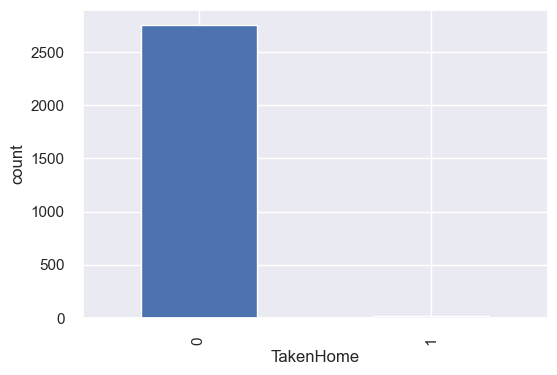

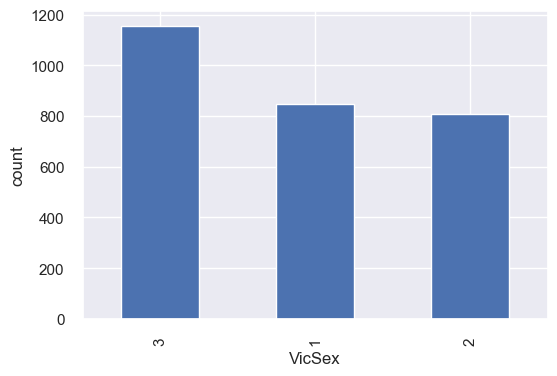

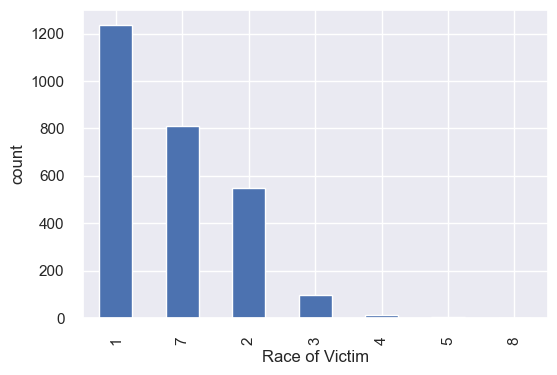

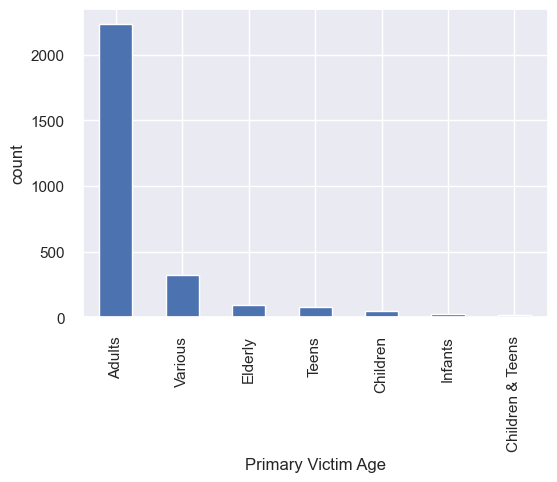

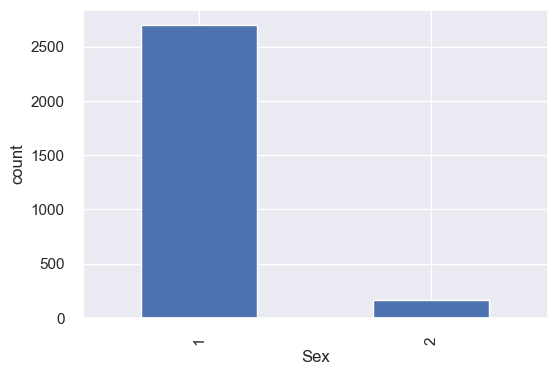

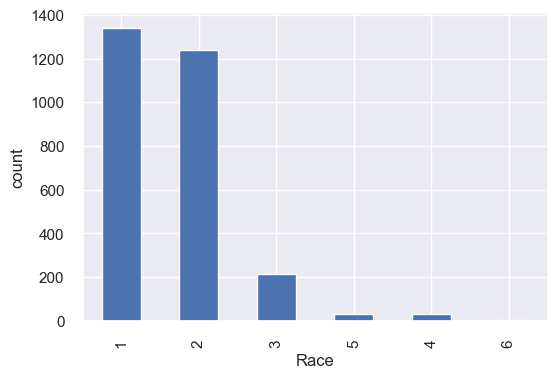

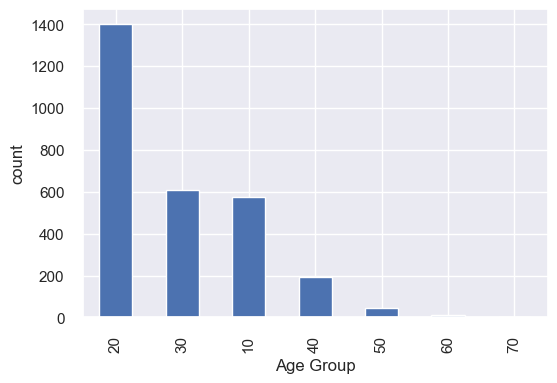

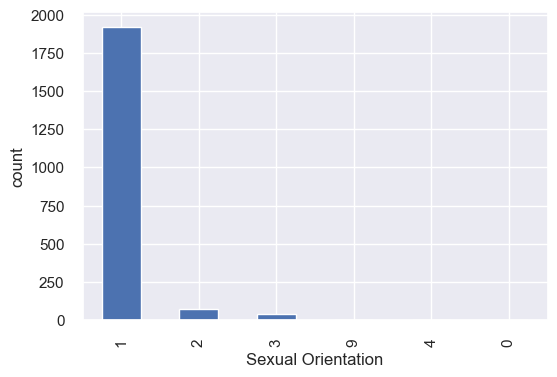

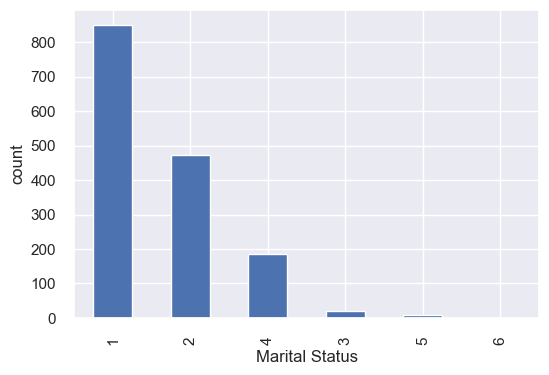

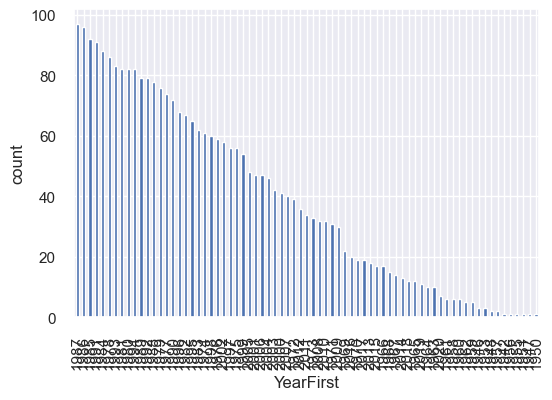

In [23]:
for i in data.columns[:-3]:
    plot_distribution(data, i)

# Killer

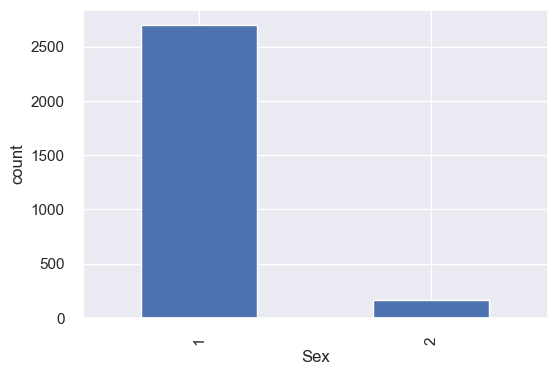

In [24]:
# We have way more males than females
plot_distribution(data, 'Sex')

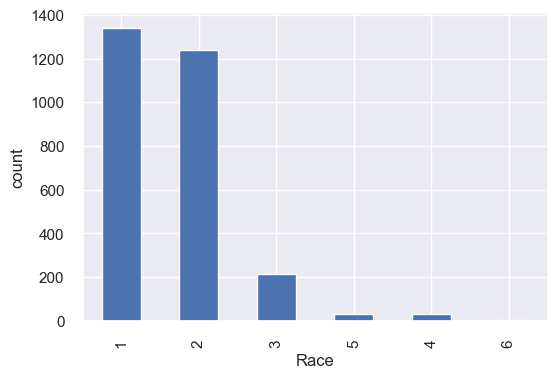

In [25]:
plot_distribution(data, 'Race')

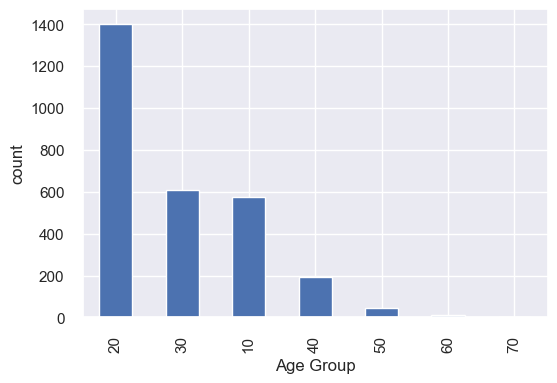

In [26]:
plot_distribution(data, 'Age Group')

# Group Race

In [27]:
data['Race'].value_counts()

1    1342
2    1238
3     216
5      30
4      30
6       2
Name: Race, dtype: int64

In [28]:
# We combine race 4, 5, 6 into group 4
data['Race'] = data['Race'].map({1: 0, 2: 1, 3: 2, 4: 3, 5: 3, 6: 3}).astype('object')

In [29]:
# We combine race 4, 5, 6 into group 4
data['Sex'] = data['Sex'].map({1: 0, 2: 1}).astype('object')

In [30]:
data['Age Group'] = data['Age Group'].map({10: 0, 20: 1, 30:2, 40:3, 50:3, 60:3, 70:3}).astype('object')
data['Age Group'].value_counts()

1.0    1402
2.0     611
0.0     577
3.0     252
Name: Age Group, dtype: int64

In [31]:
data['Sex'].value_counts()

0    2706
1     169
Name: Sex, dtype: int64

In [32]:
data['Race'].value_counts()

0.0    1342
1.0    1238
2.0     216
3.0      62
Name: Race, dtype: int64

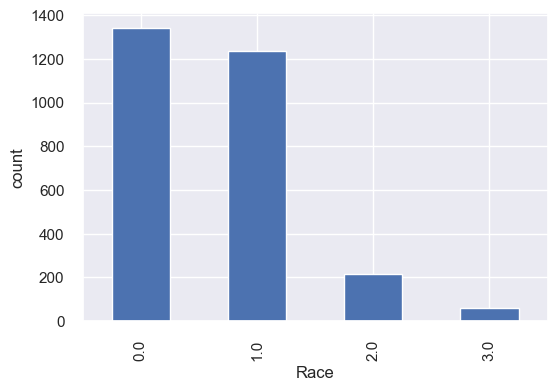

In [33]:
plot_distribution(data, 'Race')

# Train-Test Split

In [34]:
data.shape

(2875, 37)

In [35]:
data.drop(['US', 'Country',"YearFirst","YearFinal"], axis=1, inplace=True)
# Drop Totem and Item Totem columns because > 50% missing data
data.drop(['Totem', 'Item Totem', 'Marital Status', 'Sexual Orientation'], axis=1, inplace=True)

# separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels = ['Sex', 'Race', 'Age Group'], axis=1),
                                                    data[['Sex', 'Race', 'Age Group']],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((2012, 26), (863, 26))

In [36]:
X_train.columns

Index(['Sexual Assault', 'Torture', 'Sought victim to kill', 'Overkill',
       'Quick', 'Blindfold', 'Bound', 'Mutilate', 'Necrophilia', 'AteBody',
       'DrankBlood', 'Posed', 'Body Totem', 'BodyLeft', 'LeftHidden',
       'LeftBuried', 'Moved', 'MovedHide', 'MovedBuried',
       'Placed in body of water', 'Body Burned', 'Dismembered', 'TakenHome',
       'VicSex', 'Race of Victim', 'Primary Victim Age'],
      dtype='object')

In [37]:
print("Done")

Done


# Data Imputation

In [38]:
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

In [39]:
def imputation(model, X_train, X_test, y_train, y_test):
    
    print("Model name = ", model)
    print("Before = ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    if model == 'frequent':
        imputer = CategoricalImputer(imputation_method='frequent')
        imputer.fit(X_train)
        X_train = imputer.transform(X_train)
        X_test = imputer.transform(X_test)
        
    elif model == 'AddMissingIndicator':
        pipe = Pipeline([
            ('missing_ind', AddMissingIndicator()),

            ('imputer_mode', CategoricalImputer(
                imputation_method='frequent'))])
        
        # fit the pipe
        pipe.fit(X_train)
        X_train = pipe.transform(X_train)
        X_test = pipe.transform(X_test)
        
    else:
        print("Error!")
    
    #Impute labels using Frequent Category Imputation
    imputer = CategoricalImputer(imputation_method='frequent')
    imputer.fit(y_train)
    y_train = imputer.transform(y_train)
    y_test = imputer.transform(y_test)
    # y_train = y_train
    # y_test = y_test
    
    print("After = ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test
        

In [40]:
# model = frequent or AddMissingIndicator
xx_train, xx_test, yy_train, yy_test = imputation(model='frequent', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Model name =  frequent
Before =  (2012, 26) (863, 26) (2012, 3) (863, 3)
After =  (2012, 26) (863, 26) (2012, 3) (863, 3)


In [41]:
xx_train.isnull().mean()

Sexual Assault             0.0
Torture                    0.0
Sought victim to kill      0.0
Overkill                   0.0
Quick                      0.0
Blindfold                  0.0
Bound                      0.0
Mutilate                   0.0
Necrophilia                0.0
AteBody                    0.0
DrankBlood                 0.0
Posed                      0.0
Body Totem                 0.0
BodyLeft                   0.0
LeftHidden                 0.0
LeftBuried                 0.0
Moved                      0.0
MovedHide                  0.0
MovedBuried                0.0
Placed in body of water    0.0
Body Burned                0.0
Dismembered                0.0
TakenHome                  0.0
VicSex                     0.0
Race of Victim             0.0
Primary Victim Age         0.0
dtype: float64

In [42]:
xx_test.isnull().mean()

Sexual Assault             0.0
Torture                    0.0
Sought victim to kill      0.0
Overkill                   0.0
Quick                      0.0
Blindfold                  0.0
Bound                      0.0
Mutilate                   0.0
Necrophilia                0.0
AteBody                    0.0
DrankBlood                 0.0
Posed                      0.0
Body Totem                 0.0
BodyLeft                   0.0
LeftHidden                 0.0
LeftBuried                 0.0
Moved                      0.0
MovedHide                  0.0
MovedBuried                0.0
Placed in body of water    0.0
Body Burned                0.0
Dismembered                0.0
TakenHome                  0.0
VicSex                     0.0
Race of Victim             0.0
Primary Victim Age         0.0
dtype: float64

In [43]:
yy_train.isnull().mean()

Sex          0.0
Race         0.0
Age Group    0.0
dtype: float64

In [44]:
yy_test.isnull().mean()

Sex          0.0
Race         0.0
Age Group    0.0
dtype: float64

In [45]:
print("Done")

Done


# Categorical Encoding

In [46]:
# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import RareLabelEncoder

In [47]:
'''
Categorical Encoding Function
'''
def cat_encoding(model, col, X_train, X_test, tolerance=None, n_categories=None, drop_last=True):
    
        print("Categorical encoding model = ", model)
        print("Before = ", X_train.shape, X_test.shape)
        
        if model == 'fe_OneHotEncoder':
            ohe_enc = fe_OneHotEncoder(
            top_categories=None,
            variables=[col],  # select which variables to encode
            drop_last=drop_last)  # to return k-1, false to return k
        
        elif model == 'RareLabelEncoder':

            # Rare value encoder
            rare_encoder = RareLabelEncoder(
            tol=tolerance,  # minimal percentage to be considered non-rare
            n_categories=n_categories, # minimal number of categories the variable should have to re-cgroup rare categories
            variables=[col]) # variables to re-group
            
            rare_encoder.fit(X_train.fillna('Missing'))
            X_train = rare_encoder.transform(X_train.fillna('Missing'))
            X_test = rare_encoder.transform(X_test.fillna('Missing'))
            
            # Visualize variables with high cardinality but low number of samples
            for col in [col]: #'Race of Victim', 

                temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )
                # make plot with the above percentages
                fig = temp_df.sort_values(ascending=False).plot.bar()
                fig.set_xlabel(col)
                # add a line at 5 % to flag the threshold for rare categories
                fig.axhline(y=0.05, color='red')
                fig.set_ylabel('Percentage')
                plt.show()
                
            ohe_enc = fe_OneHotEncoder(
            top_categories=None,
            variables=[col],  # select which variables to encode
            drop_last=drop_last)  # to return k-1, false to return k
            
        else:
            print("Error!")
            
        # Fit encoder
        ohe_enc.fit(X_train.fillna('Missing'))

        # Transform Encoder
        X_train = ohe_enc.transform(X_train.fillna('Missing'))
        X_test = ohe_enc.transform(X_test.fillna('Missing'))

        print("After = ", X_train.shape, X_test.shape)
        return X_train, X_test


Categorical encoding model =  RareLabelEncoder
Before =  (2012, 26) (863, 26)


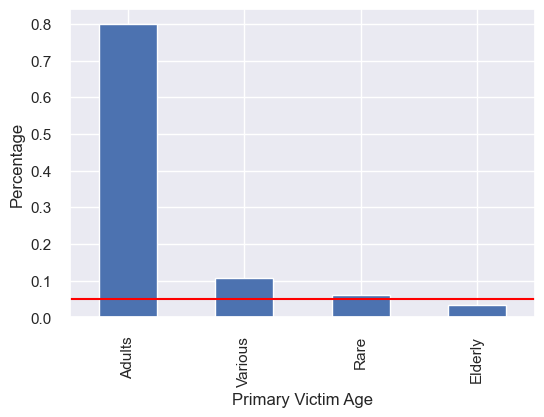

After =  (2012, 28) (863, 28)


In [48]:
#model = RareLabelEncoder  OR fe_OneHotEncoder
xx_train, xx_test = cat_encoding(model='RareLabelEncoder', col='Primary Victim Age', X_train=xx_train, X_test=xx_test, tolerance=0.03, n_categories=4, drop_last=True) 

In [49]:
xx_train.head(2)

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,MovedBuried,Placed in body of water,Body Burned,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Various,Primary Victim Age_Rare
3444,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,2,2,1,0,0
3149,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,3,1,0,0


In [50]:
print("Done")

Done


## Concat

In [51]:
# Concat training and testng data for stratified train_test split

xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

upper = xx_train.join(yy_train)
upper.shape

lower = xx_test.join(yy_test)
lower.shape

df = pd.concat([upper, lower], axis=0)
df.shape

df.head()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Various,Primary Victim Age_Rare,Sex,Race,Age Group
3444,0,0,0,1,0,0,1,0,0,0,...,0,0,2,2,1,0,0,0,1.0,2.0
3149,0,0,0,0,1,0,0,0,0,0,...,0,0,1,3,1,0,0,0,2.0,2.0
30,0,0,1,0,0,0,0,0,0,0,...,0,0,1,7,1,0,0,0,1.0,2.0
2350,1,0,1,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0.0,1.0
2540,0,0,1,0,0,0,0,0,0,0,...,0,0,3,7,1,0,0,0,1.0,3.0


In [52]:
df.to_csv('output1.csv', index=False)  

In [53]:
print("Done")

Done


# Predicting Sex

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [55]:
'''
Run this cell before running any prediction for Sex
'''

# separate into training and testing set
n_test = 3
X = df[df.columns[:-n_test]]
y = df[['Sex']]
xx_train,xx_test, yy_train, yy_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)

In [56]:
xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

((2012, 28), (2012, 1), (863, 28), (863, 1))

In [57]:
print("Done")

Done


In [58]:
yy_test.value_counts(normalize=True)

Sex
0      0.940904
1      0.059096
dtype: float64

In [59]:
yy_train.value_counts(normalize=True)

Sex
0      0.941352
1      0.058648
dtype: float64

In [60]:
yy_train.value_counts()

Sex
0      1894
1       118
dtype: int64

In [61]:
from sklearn.utils.multiclass import type_of_target
type_of_target(yy_test)

'binary'

## Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler

### Decision Tree Classifier with and without SMOTE

Without SMOTE: 

Train Mean ROC AUC: 0.641
Test Mean ROC AUC: 0.662
Test Accuracy: 0.93279258400927
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       812
           1       0.40      0.27      0.33        51

    accuracy                           0.93       863
   macro avg       0.68      0.62      0.65       863
weighted avg       0.92      0.93      0.93       863



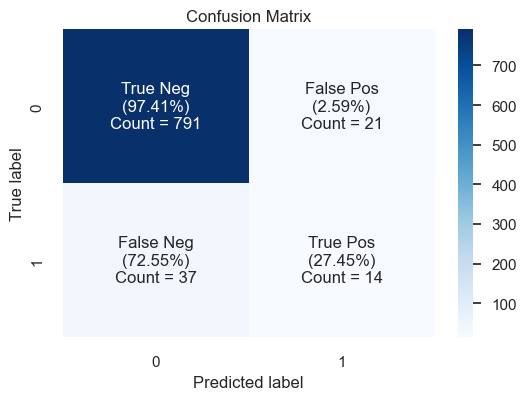

SMOTE: 

Train Mean ROC AUC: 0.643
Test Mean ROC AUC: 0.660
Test Accuracy: 0.7833140208574739
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       812
           1       0.17      0.67      0.27        51

    accuracy                           0.78       863
   macro avg       0.57      0.73      0.57       863
weighted avg       0.93      0.78      0.84       863



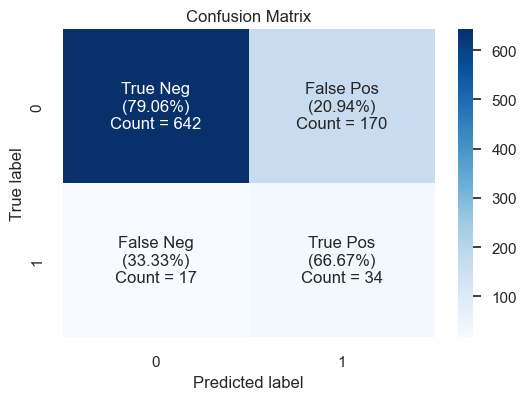

In [63]:
print("Without SMOTE: \n")
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_test = cross_val_score(model, xx_test, yy_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))
print('Test Mean ROC AUC: %.3f' % mean(scores_test))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

dtc = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', dtc)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))
scores_train = cross_val_score(dtc, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_test = cross_val_score(dtc, xx_test, yy_test, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))
print('Test Mean ROC AUC: %.3f' % mean(scores_test))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


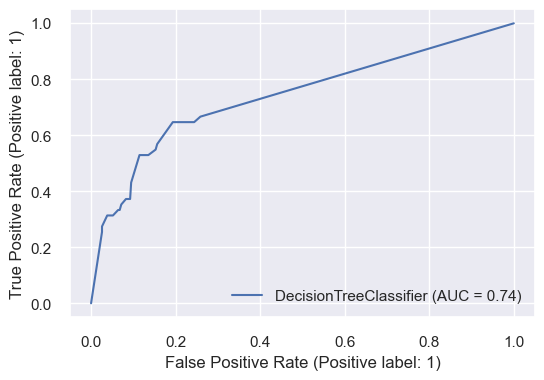

In [64]:
dtc_disp = plot_roc_curve(model, xx_test, yy_test)

### Random Forest Classifier with and without SMOTE

In [65]:
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200, 500, 1000]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(xx_train, yy_train['Sex'])
#save best model
rf_best_sex = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
n_estimators = rf_gs.best_params_.get('n_estimators')

{'n_estimators': 200}


Without SMOTE: 

Mean ROC AUC: 0.712
Accuracy: 0.9432213209733488
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       812
           1       0.56      0.20      0.29        51

    accuracy                           0.94       863
   macro avg       0.75      0.59      0.63       863
weighted avg       0.93      0.94      0.93       863



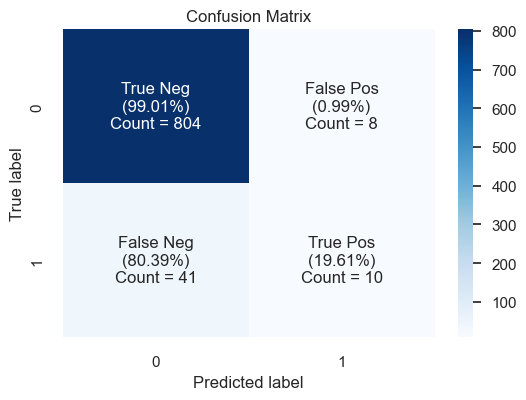

SMOTE: 

Mean ROC AUC: 0.781
Accuracy: 0.86558516801854
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       812
           1       0.25      0.63      0.36        51

    accuracy                           0.87       863
   macro avg       0.61      0.75      0.64       863
weighted avg       0.93      0.87      0.89       863



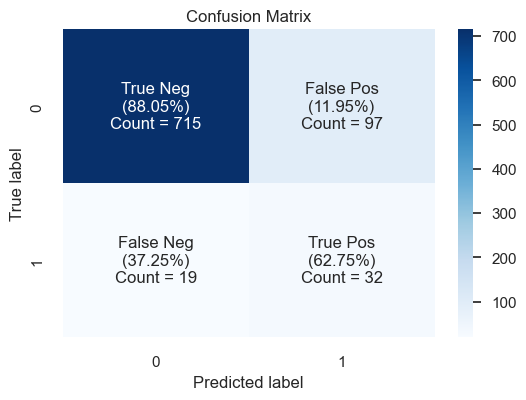

In [66]:
print("Without SMOTE: \n")
# define model
model = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

# define pipeline
print("SMOTE: \n")

rf = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rf)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


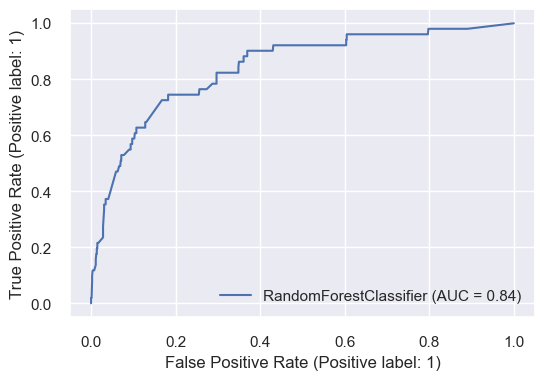

In [67]:
rf_disp = plot_roc_curve(rf, xx_test, yy_test)

### Simple Random Forest

In [68]:
# Instantiate model with 1000 decision trees
rf_sex = RandomForestClassifier(n_estimators = n_estimators, random_state = 42)
# Train the model on training data
rf_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = rf_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.9432213209733488


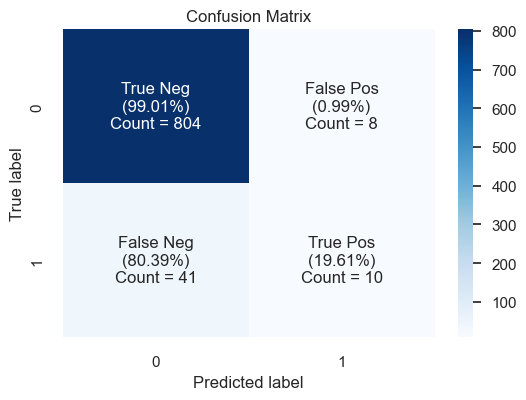

In [69]:
conf_matrix(yy_test, 'Sex', yy_pred)

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegression

### Simple Logistic Regression

In [71]:
# all parameters not specified are set to their defaults
log_reg_sex = LogisticRegression(random_state=42)
log_reg_sex.fit(xx_train, yy_train['Sex'])
yy_pred = log_reg_sex.predict(xx_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))

Accuracy: 0.944380069524913
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       812
           1       1.00      0.06      0.11        51

    accuracy                           0.94       863
   macro avg       0.97      0.53      0.54       863
weighted avg       0.95      0.94      0.92       863



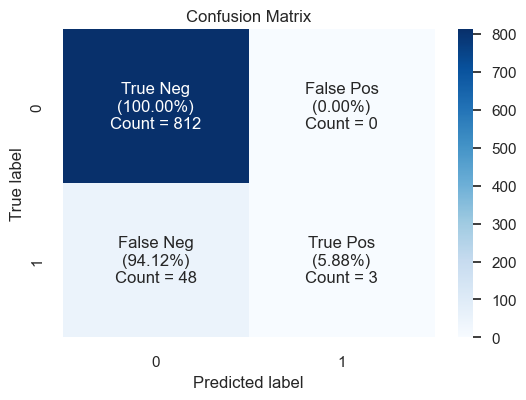

In [72]:
conf_matrix(yy_test, 'Sex', yy_pred)

### Logistic Regression with and without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.728
Accuracy: 0.944380069524913
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       812
           1       1.00      0.06      0.11        51

    accuracy                           0.94       863
   macro avg       0.97      0.53      0.54       863
weighted avg       0.95      0.94      0.92       863



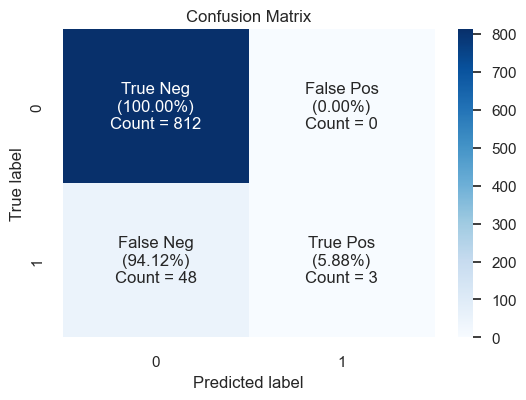

SMOTE: 

Mean ROC AUC: 0.776
Accuracy: 0.8829663962920047
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       812
           1       0.27      0.59      0.37        51

    accuracy                           0.88       863
   macro avg       0.62      0.74      0.65       863
weighted avg       0.93      0.88      0.90       863



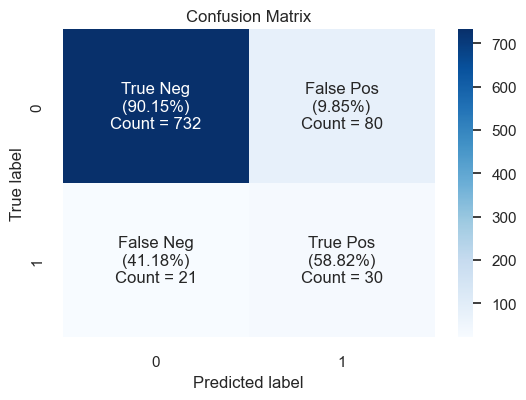

In [73]:
print("Without SMOTE: \n")
# define model
model = LogisticRegression()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

logit = LogisticRegression()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', logit)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


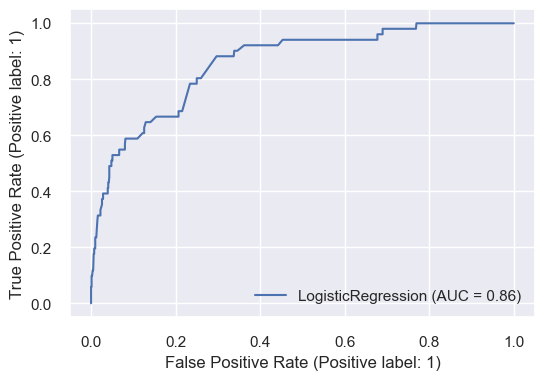

In [74]:
logit_disp = plot_roc_curve(logit, xx_test, yy_test)

## AdaBoost

In [75]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

### Simple AdaBoost

In [76]:
# Instantiate model with 1000 decision trees
ada_sex = AdaBoostClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data
ada_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = ada_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.9432213209733488


#### AdaBoost with and without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.752
Accuracy: 0.9455388180764774
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.75      0.12      0.20        51

    accuracy                           0.95       863
   macro avg       0.85      0.56      0.59       863
weighted avg       0.94      0.95      0.93       863



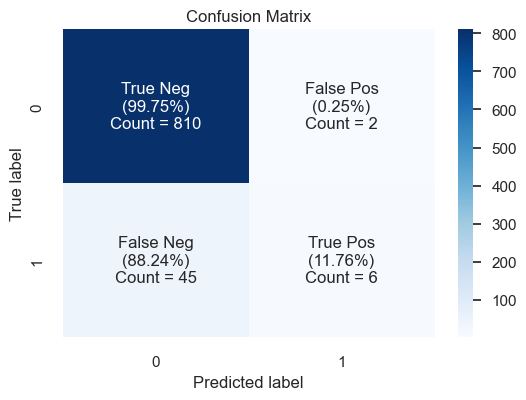

SMOTE: 

Mean ROC AUC: 0.788
Accuracy: 0.8632676709154113
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       812
           1       0.25      0.65      0.36        51

    accuracy                           0.86       863
   macro avg       0.61      0.76      0.64       863
weighted avg       0.93      0.86      0.89       863



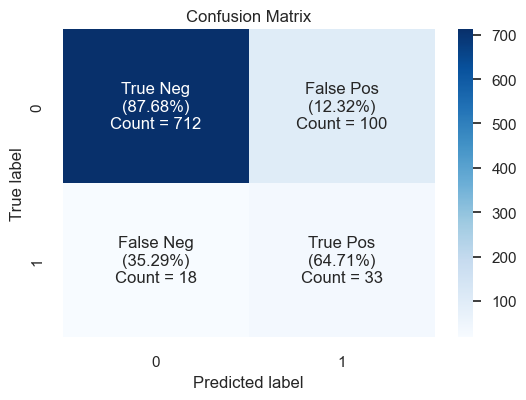

In [77]:
print("Without SMOTE: \n")
# define model
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

ada = AdaBoostClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', ada)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


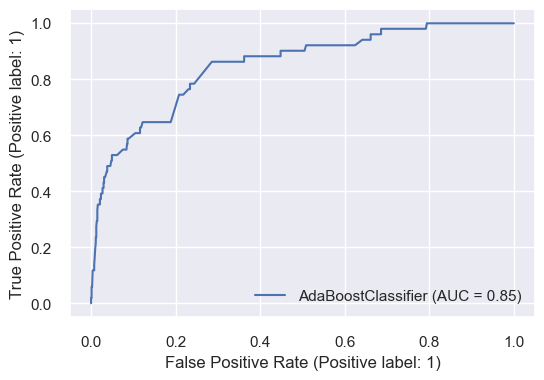

In [78]:
ada_disp = plot_roc_curve(ada, xx_test, yy_test)

## XGBoost

In [79]:
from xgboost import XGBClassifier

Without SMOTE: 

Mean ROC AUC: 0.733
Accuracy: 0.9409038238702202
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       812
           1       0.50      0.20      0.28        51

    accuracy                           0.94       863
   macro avg       0.73      0.59      0.63       863
weighted avg       0.92      0.94      0.93       863



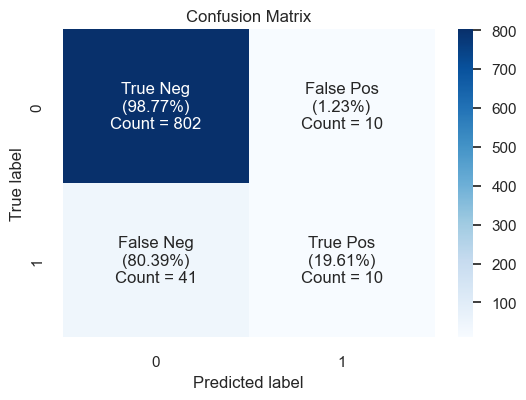

SMOTE: 

Mean ROC AUC: 0.772
Accuracy: 0.8366164542294322
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       812
           1       0.18      0.49      0.26        51

    accuracy                           0.84       863
   macro avg       0.57      0.67      0.58       863
weighted avg       0.92      0.84      0.87       863



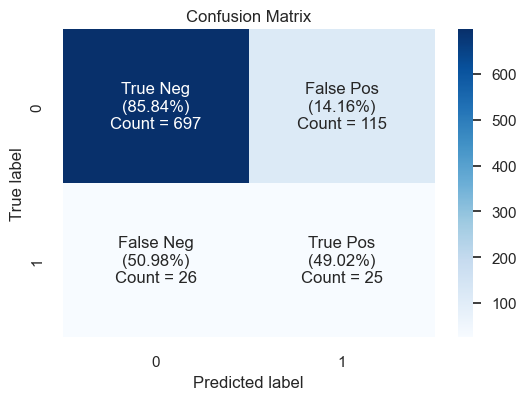

In [80]:
print("Without SMOTE: \n")
# define model
model = XGBClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

xg = XGBClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', xg)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


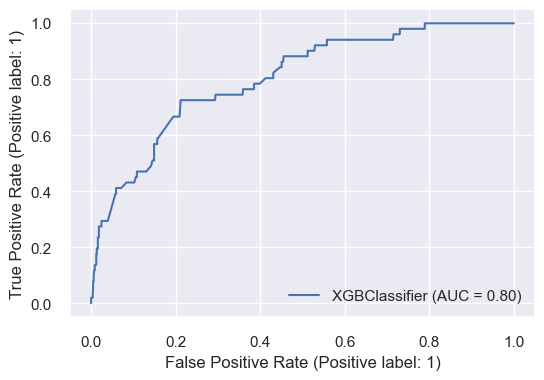

In [81]:
xg_disp = plot_roc_curve(xg, xx_test, yy_test)

## KNN

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Simple KNN

In [83]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(xx_train, yy_train['Sex'])

#save best model
knn_best_sex = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
n_neighbors = knn_gs.best_params_.get('n_neighbors')

{'n_neighbors': 11}


In [84]:
knn_sex = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the model on training data
knn_sex.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = knn_sex.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

Accuracy: 0.9420625724217845


### KNN with and Without SMOTE

Without SMOTE: 

Mean ROC AUC: 0.676
Accuracy: 0.9420625724217845
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.57      0.08      0.14        51

    accuracy                           0.94       863
   macro avg       0.76      0.54      0.55       863
weighted avg       0.92      0.94      0.92       863



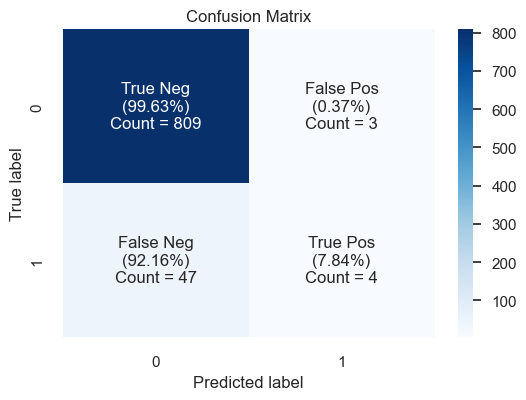

SMOTE: 

Mean ROC AUC: 0.752
Accuracy: 0.8482039397450754
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       812
           1       0.19      0.49      0.28        51

    accuracy                           0.85       863
   macro avg       0.58      0.68      0.60       863
weighted avg       0.92      0.85      0.88       863



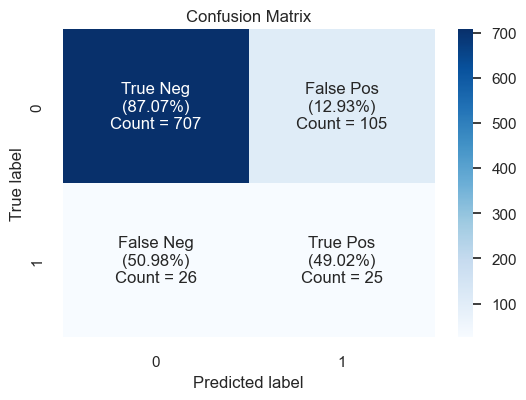

In [85]:
print("Without SMOTE: \n")
# define model
model = KNeighborsClassifier(n_neighbors=n_neighbors)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

knn = KNeighborsClassifier()
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', knn)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


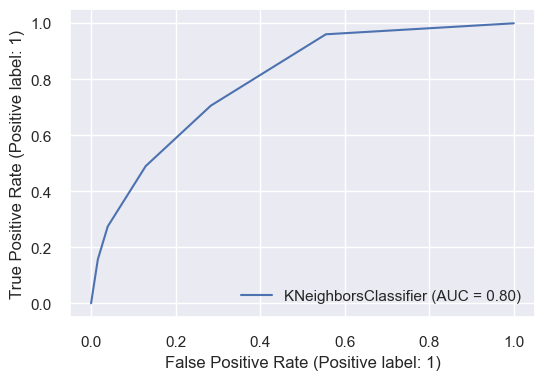

In [86]:
knn_disp = plot_roc_curve(knn, xx_test, yy_test)

## SVM

In [87]:
# import SVC classifier
from sklearn import svm

Without SMOTE: 

Mean ROC AUC: 0.710
Accuracy: 0.9409038238702202
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       812
           1       0.00      0.00      0.00        51

    accuracy                           0.94       863
   macro avg       0.47      0.50      0.48       863
weighted avg       0.89      0.94      0.91       863



C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


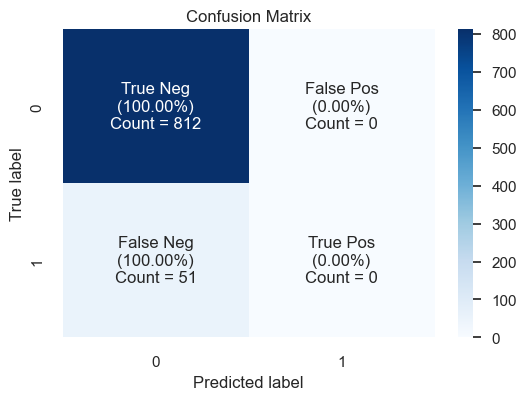

SMOTE: 

Mean ROC AUC: 0.779
Accuracy: 0.9281575898030128
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       812
           1       0.37      0.31      0.34        51

    accuracy                           0.93       863
   macro avg       0.66      0.64      0.65       863
weighted avg       0.92      0.93      0.93       863



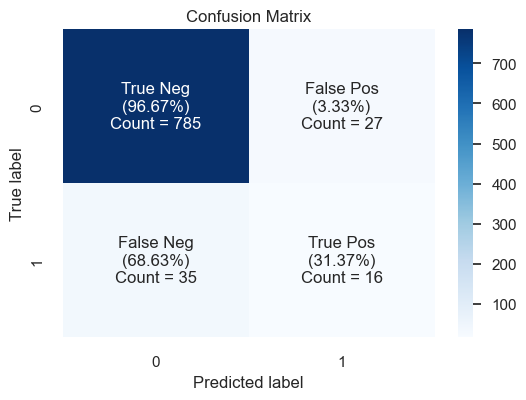

In [88]:
print("Without SMOTE: \n")
# define model
model = svm.SVC(kernel='rbf')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

svm = svm.SVC(kernel='rbf')
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', svm)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


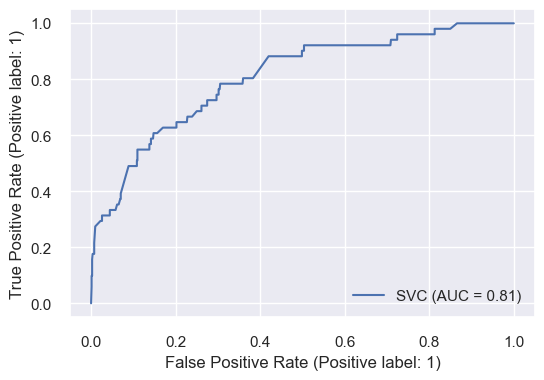

In [89]:
svm_disp = plot_roc_curve(svm, xx_test, yy_test)

## Voting Classifier: Sex

In [90]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best_sex.score(xx_test, yy_test.Sex)))
print('rf: {}'.format(rf_best_sex.score(xx_test, yy_test.Sex)))
print('log_reg: {}'.format(log_reg_sex.score(xx_test, yy_test.Sex)))

knn: 0.9420625724217845
rf: 0.9420625724217845
log_reg: 0.944380069524913


### Simple Ensemble

In [91]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best_sex), ('rf', rf_best_sex), ('log_reg', log_reg_sex)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(xx_train, yy_train['Sex'])
#test our model on the test data
print(ensemble.score(xx_test, yy_test.Sex))

yy_pred = ensemble.predict(xx_test).round()# print classification report
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

0.9455388180764774
Accuracy: 0.9455388180764774


### Ensemble with and without SMOTE

Without SMOTE: 

Mean ROC AUC: nan
Accuracy: 0.9455388180764774
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       812
           1       0.75      0.12      0.20        51

    accuracy                           0.95       863
   macro avg       0.85      0.56      0.59       863
weighted avg       0.94      0.95      0.93       863



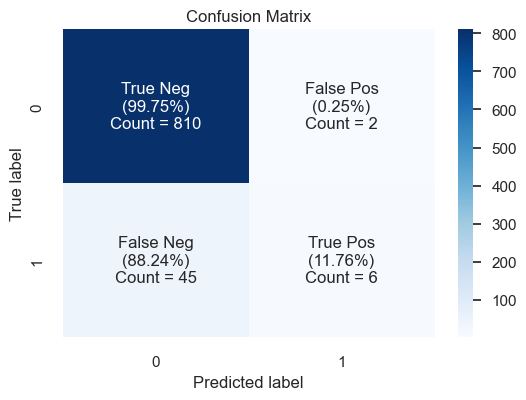

SMOTE: 

Mean ROC AUC: nan
Accuracy: 0.8887601390498262
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       812
           1       0.26      0.49      0.34        51

    accuracy                           0.89       863
   macro avg       0.61      0.70      0.64       863
weighted avg       0.92      0.89      0.90       863



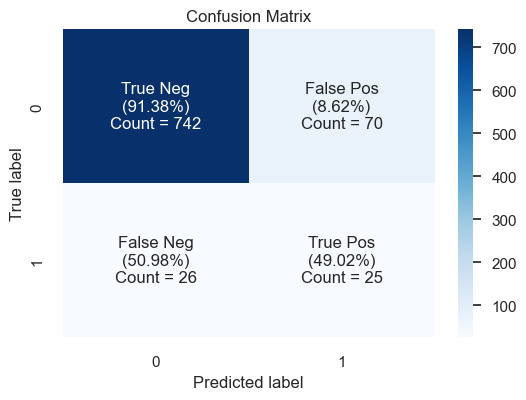

In [92]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('knn', knn_best_sex), ('rf', rf_best_sex), ('log_reg', log_reg_sex)]


print("Without SMOTE: \n")
# define model
model = VotingClassifier(estimators, voting='hard')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
model.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

ensemble = VotingClassifier(estimators, voting='hard')
over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', ensemble)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Sex']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Sex, yy_pred))

# print classification report
print(classification_report(yy_test.Sex, yy_pred))
conf_matrix(yy_test, 'Sex', yy_pred)

In [93]:
# ensemble_disp = plot_roc_curve(ensemble, xx_test, yy_test)

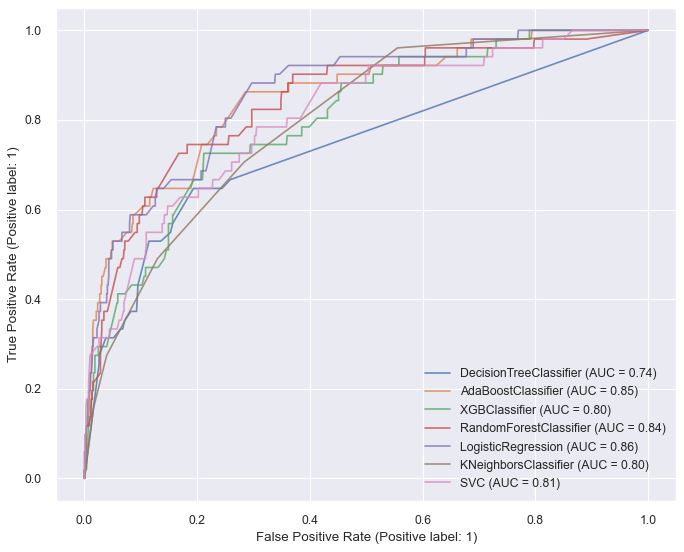

In [94]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
dtc_disp.plot(ax=ax, alpha=0.8)
ada_disp.plot(ax=ax, alpha=0.8)
xg_disp.plot(ax=ax, alpha=0.8)
rf_disp.plot(ax=ax, alpha=0.8)
logit_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svm_disp.plot(ax=ax, alpha=0.8)
#ensemble_disp.plot(ax=ax, alpha=0.8)

C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\yudhi\anaconda3\envs\tf_2.5\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is dep

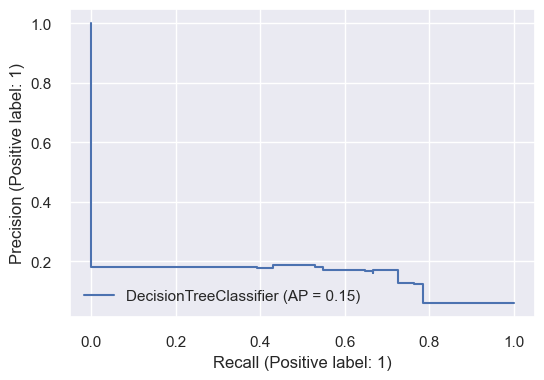

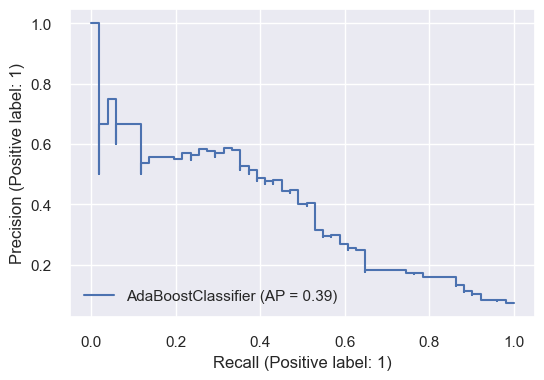

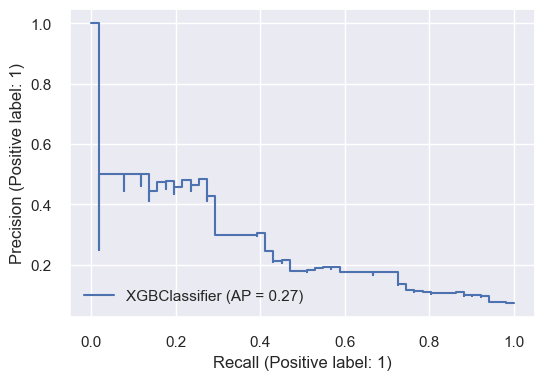

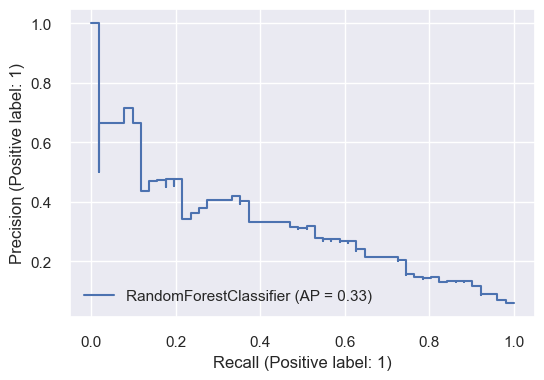

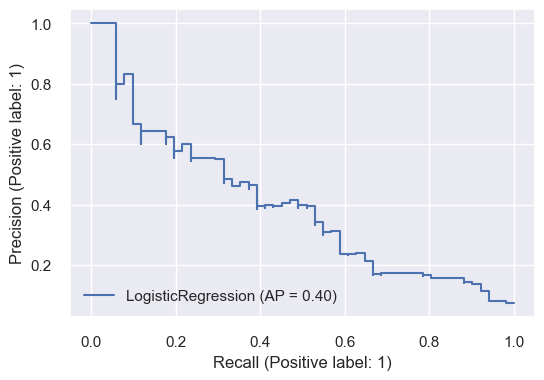

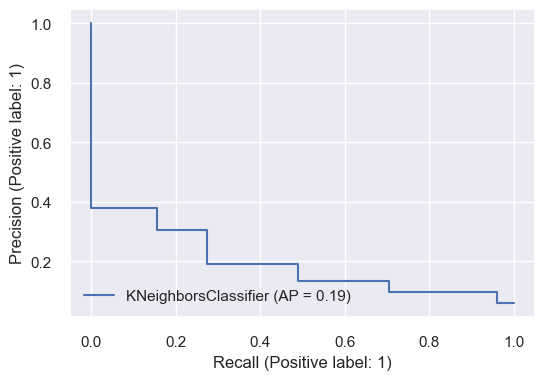

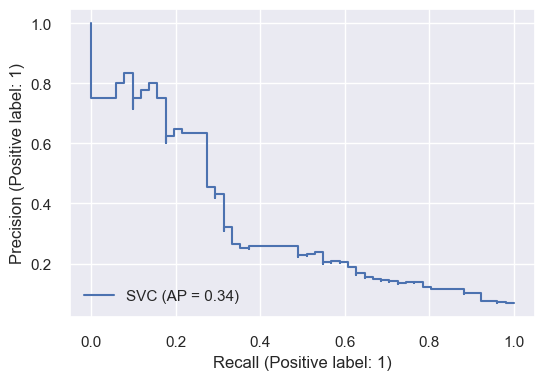

In [95]:
dtc_disp = plot_precision_recall_curve(dtc, xx_test, yy_test)
ada_disp = plot_precision_recall_curve(ada, xx_test, yy_test)
xg_disp = plot_precision_recall_curve(xg, xx_test, yy_test)
rf_disp = plot_precision_recall_curve(rf, xx_test, yy_test)
logit_disp = plot_precision_recall_curve(logit, xx_test, yy_test)
knn_disp = plot_precision_recall_curve(knn, xx_test, yy_test)
svm_disp = plot_precision_recall_curve(svm, xx_test, yy_test)

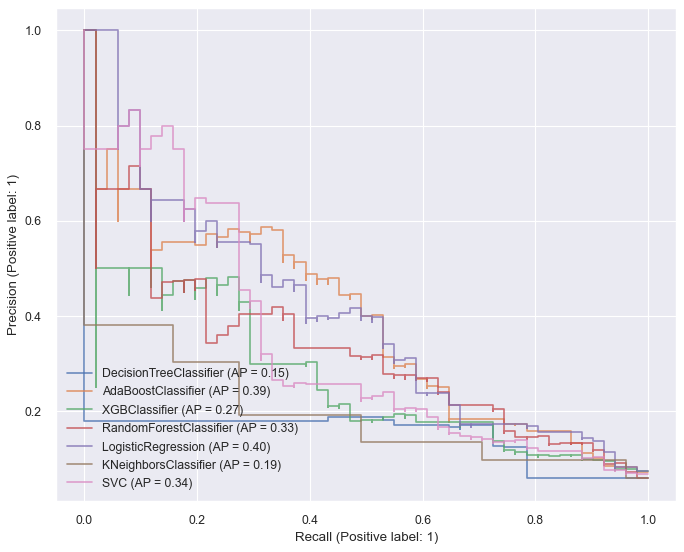

In [96]:
figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
dtc_disp.plot(ax=ax, alpha=0.8)
ada_disp.plot(ax=ax, alpha=0.8)
xg_disp.plot(ax=ax, alpha=0.8)
rf_disp.plot(ax=ax, alpha=0.8)
logit_disp.plot(ax=ax, alpha=0.8)
knn_disp.plot(ax=ax, alpha=0.8)
svm_disp.plot(ax=ax, alpha=0.8)

## Neural Network

In [97]:
import tensorflow as tf
print(tf.__version__)

2.5.0


### NN without SMOTE

In [98]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train, 
                    tf.one_hot(yy_train['Sex'], depth=2),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Sex'], depth=2)))

Epoch 1/100
63/63 [==============================] - 3s 7ms/step - loss: 0.2421 - accuracy: 0.9414 - val_loss: 0.2080 - val_accuracy: 0.9409
Epoch 2/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2043 - accuracy: 0.9414 - val_loss: 0.1861 - val_accuracy: 0.9409
Epoch 3/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1950 - accuracy: 0.9414 - val_loss: 0.1829 - val_accuracy: 0.9409
Epoch 4/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.9414 - val_loss: 0.2102 - val_accuracy: 0.9409
Epoch 5/100
63/63 [==============================] - 0s 3ms/step - loss: 0.2009 - accuracy: 0.9414 - val_loss: 0.1891 - val_accuracy: 0.9409
Epoch 6/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9414 - val_loss: 0.1780 - val_accuracy: 0.9409
Epoch 7/100
63/63 [==============================] - 0s 3ms/step - loss: 0.1943 - accuracy: 0.9414 - val_loss: 0.1805 - val_accuracy: 0.9409
Epoch 8/100
6

Text(0.5, 1.0, 'Model training curves: Sex')

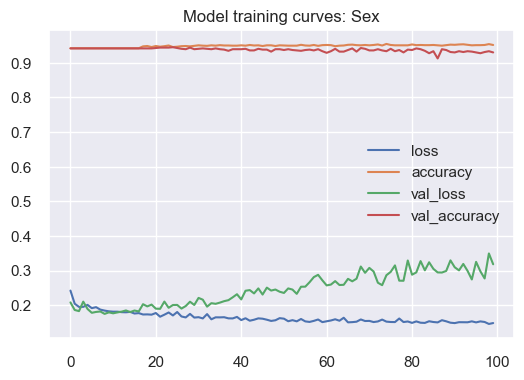

In [99]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: Sex")

### NN with SMOTE

In [100]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
xx_train_sm, yy_train_sm = sm.fit_resample(xx_train, yy_train.values.ravel())

# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train_sm, 
                    tf.one_hot(yy_train_sm, depth=2),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Sex'], depth=2)))

Epoch 1/100
119/119 [==============================] - 1s 4ms/step - loss: 0.5401 - accuracy: 0.7099 - val_loss: 0.3253 - val_accuracy: 0.8783
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 0.4525 - accuracy: 0.7746 - val_loss: 0.4484 - val_accuracy: 0.7775
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 0.4310 - accuracy: 0.7875 - val_loss: 0.4789 - val_accuracy: 0.7242
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 0.4216 - accuracy: 0.7899 - val_loss: 0.5367 - val_accuracy: 0.6883
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 0.4153 - accuracy: 0.7936 - val_loss: 0.5833 - val_accuracy: 0.6883
Epoch 6/100
119/119 [==============================] - 0s 2ms/step - loss: 0.4075 - accuracy: 0.7975 - val_loss: 0.3616 - val_accuracy: 0.8366
Epoch 7/100
119/119 [==============================] - 0s 2ms/step - loss: 0.3986 - accuracy: 0.8057 - val_loss: 0.4477 - val_accuracy: 0.7358

Text(0.5, 1.0, 'Model training curves: SMOTE Sex')

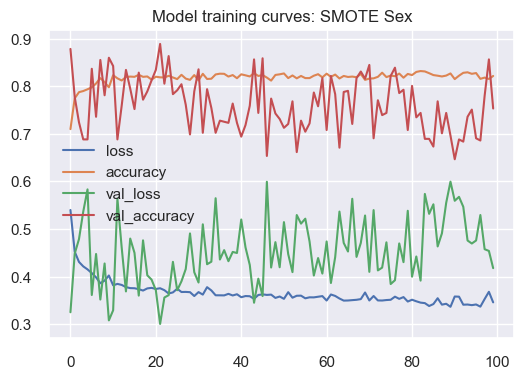

In [101]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: SMOTE Sex")

# Predicting Race

In [102]:
'''
Run this cell before running any prediction for Race
'''

# separate into training and testing set
n_test = 2
X = df[df.columns[:-n_test]]
y = df[['Race']]
xx_train,xx_test, yy_train, yy_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)

xx_train.shape, yy_train.shape, xx_test.shape, yy_test.shape

((2012, 29), (2012, 1), (863, 29), (863, 1))

## Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

### Simple Random Forest

In [104]:
#create a new random forest classifier
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200, 500, 1000]}
#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)
#fit model to training data
rf_gs.fit(xx_train, yy_train['Race'])
#save best model
rf_best_race = rf_gs.best_estimator_
#check best n_estimators value
print(rf_gs.best_params_)
n_estimators = rf_gs.best_params_.get('n_estimators')

# Instantiate model with 1000 decision trees
rf_race = RandomForestRegressor(n_estimators = n_estimators, random_state = 42)
# Train the model on training data
rf_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = rf_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

{'n_estimators': 1000}
Accuracy: 0.6767091541135574


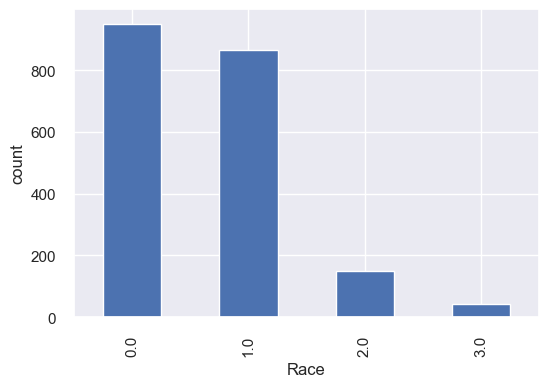

In [105]:
plot_distribution(yy_train, column ='Race')

In [106]:
yy_train.value_counts()

Race
0.0     951
1.0     866
2.0     151
3.0      44
dtype: int64

### Random Forest Classifier with and without SMOTE

In [107]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

Without SMOTE: 

Train Mean ROC AUC: nan
Accuracy: 0.712630359212051
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       408
         1.0       0.71      0.75      0.73       372
         2.0       0.57      0.26      0.36        65
         3.0       0.10      0.06      0.07        18

    accuracy                           0.71       863
   macro avg       0.53      0.46      0.48       863
weighted avg       0.70      0.71      0.70       863

SMOTE: 

Train Mean ROC AUC: nan


ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 951 samples and 785 samples are asked.

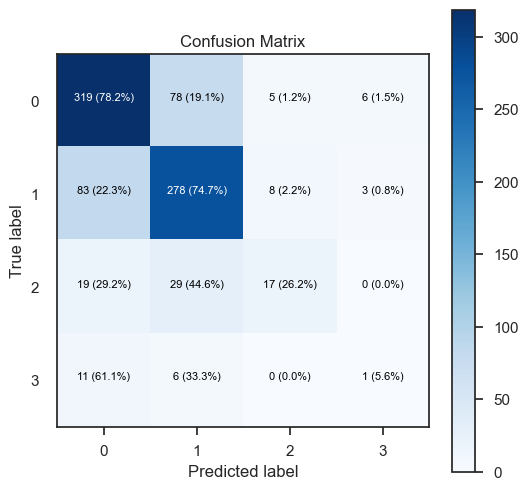

In [108]:
print("Without SMOTE: \n")
# define model
model = RandomForestClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = RandomForestClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

### Decision Tree Classifier with and without SMOTE

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
print("Without SMOTE: \n")
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))


# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = DecisionTreeClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))


# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# all parameters not specified are set to their defaults
log_reg_race = LogisticRegression(random_state=42, multi_class='multinomial')
log_reg_race.fit(xx_train, yy_train['Race'])
yy_pred = log_reg_race.predict(xx_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

In [ ]:
from sklearn import linear_model
from sklearn import model_selection

In [ ]:
log_reg_race = linear_model.LogisticRegression(multi_class='multinomial')
log_reg_race.fit(xx_train, yy_train['Race'])
yy_pred = log_reg_race.predict(xx_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
print("Without SMOTE: \n")
# define model
model = LogisticRegression(max_iter=1000, multi_class='multinomial')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = LogisticRegression(max_iter=1000, multi_class='multinomial')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
print("Without SMOTE: \n")
# define model
model = XGBClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = XGBClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

### Simple AdaBoost

In [ ]:
# Instantiate model with 1000 decision trees
ada_race = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1, random_state = 42)
# Train the model on training data
ada_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = ada_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

In [ ]:
ada_race = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME", random_state = 42)
# Train the model on training data
ada_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = ada_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

### AdaBoost with and without SMOTE

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
print("Without SMOTE: \n")
# define model
model = AdaBoostClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = AdaBoostClassifier()
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

### Simple KNN

In [ ]:
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(xx_train, yy_train['Race'])

#save best model
knn_best_race = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)
n_neighbors = knn_gs.best_params_.get('n_neighbors')

knn_race = KNeighborsClassifier(n_neighbors=n_neighbors)

# Train the model on training data
knn_race.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = knn_race.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

### KNN with and without SMOTE

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
print("Without SMOTE: \n")
# define model
model = KNeighborsClassifier(n_neighbors=n_neighbors)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = KNeighborsClassifier(n_neighbors=n_neighbors)
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## SVM

In [ ]:
from sklearn import svm

In [ ]:
print("Without SMOTE: \n")
# define model
model = svm.SVC(kernel='linear')
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = svm.SVC(kernel='linear')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Voting Classifier: Race

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
#test the three models with the test data and print their accuracy scores
print('knn: {}'.format(knn_best_race.score(xx_test, yy_test.Race)))
print('rf: {}'.format(rf_best_race.score(xx_test, yy_test.Race)))
print('log_reg: {}'.format(log_reg_race.score(xx_test, yy_test.Race)))

#create a dictionary of our models
estimators=[('knn', knn_best_race), ('rf', rf_best_race), ('log_reg', log_reg_race)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(xx_train, yy_train['Race'])
#test our model on the test data
ensemble.score(xx_test, yy_test.Race)

### Ensemble with and without SMOTE

In [ ]:
# # transform the dataset
# oversample = SMOTE()
# X, y = oversample.fit_resample(xx_train, yy_train)

In [ ]:
#create a dictionary of our models
estimators=[('knn', knn_best_race), ('rf', rf_best_race), ('log_reg', log_reg_race)]
#create our voting classifier, inputting our models
model = VotingClassifier(estimators, voting='hard')

print("Without SMOTE: \n")
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
model.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = model.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))

# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

#The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, 
# then evaluate the model on the stratified but non-transformed test set.

#This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
# This pipeline can then be evaluated using repeated k-fold cross-validation.

print("SMOTE: \n")

model = VotingClassifier(estimators, voting='hard')
strategy = {0:785, 1:785, 2:785, 3:785}
over = SMOTE(sampling_strategy=strategy)
under = RandomUnderSampler(sampling_strategy=strategy)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_train = cross_val_score(model, xx_train, yy_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Train Mean ROC AUC: %.3f' % mean(scores_train))

# Train the model on training data
pipeline.fit(xx_train, yy_train['Race']);

# Use the forest's predict method on the test data
yy_pred = pipeline.predict(xx_test).round()

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(yy_test.Race, yy_pred))

# print classification report
print(classification_report(yy_test.Race, yy_pred))
# Make a prettier confusion matrix
make_confusion_matrix(y_true=yy_test.Race, 
                      y_pred=yy_pred,
                      classes=None,
                      figsize=(6, 6),
                      text_size=8)

## Neural Network

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(10, activation="ReLU"),
  tf.keras.layers.Dense(4, activation="softmax")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(xx_train, 
                    tf.one_hot(yy_train['Race'], depth=4),
                       epochs=100,
                       validation_data=(xx_test, tf.one_hot(yy_test['Race'], depth=4)))

In [ ]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model training curves: Race")